In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import random
import copy
import time
from datetime import datetime

# Thiết lập seed cho tính nhất quán
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

In [2]:
#----------------------------------------------------------------------------------------
# Tiền xử lý dữ liệu
#----------------------------------------------------------------------------------------
def preprocess_supermarket_sales(file_path):
    """
    Tiền xử lý bộ dữ liệu Supermarket Sales
    """
    print(f"Đang đọc dữ liệu từ {file_path}...")
    
    # Đọc dữ liệu CSV
    df = pd.read_csv(file_path)
    print(f"Số dòng dữ liệu ban đầu: {len(df)}")
    
    # Kiểm tra các tên cột thực tế
    print("Các cột có trong dữ liệu:")
    print(df.columns.tolist())
    
    # Chuyển đổi cột ngày tháng
    df['Date'] = pd.to_datetime(df['Date'])
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Weekday'] = df['Date'].dt.dayofweek
    
    # Tạo ID sản phẩm duy nhất từ kết hợp Product line và Branch
    df['ProductID'] = df['Product line'] + '_' + df['Branch']
    
    # Tính toán chi phí - sử dụng cogs (cost of goods sold)
    df['Cost'] = df['cogs'] / df['Quantity']  # Chi phí trên mỗi đơn vị
    df['Profit'] = df['gross income']  # Lợi nhuận gộp
    
    # Tạo biến mùa vụ dựa trên tháng
    df['Season'] = pd.cut(
        df['Month'], 
        bins=[0, 3, 6, 9, 12], 
        labels=['Winter', 'Spring', 'Summer', 'Fall']
    )
    
    # Nhóm dữ liệu theo ngày và sản phẩm
    daily_product_sales = df.groupby(['Date', 'ProductID']).agg({
        'Unit price': 'mean',
        'Quantity': 'sum',
        'Cost': 'mean',
        'Profit': 'sum',
        'Rating': 'mean',
        'Month': 'first',
        'Weekday': 'first',
        'Product line': 'first'  # Cần giữ lại thông tin này cho bước tiếp theo
    }).reset_index()
    
    # Tính giá trung bình của đối thủ (giả định là giá trung bình của sản phẩm cùng loại ở branch khác)
    competitor_prices = df.groupby(['Date', 'Product line']).agg({
        'Unit price': 'mean'
    }).rename(columns={'Unit price': 'Competitor price'}).reset_index()
    
    # Kết hợp với dữ liệu chính
    daily_product_sales = pd.merge(
        daily_product_sales,
        competitor_prices,
        on=['Date', 'Product line'],
        how='left'
    )
    
    # Tạo biến thời gian cho hiệu ứng mùa vụ
    date_range = (daily_product_sales['Date'].max() - daily_product_sales['Date'].min()).days
    if date_range > 0:  # Tránh chia cho 0
        daily_product_sales['TimeFactor'] = (daily_product_sales['Date'] - daily_product_sales['Date'].min()).dt.days / date_range
        daily_product_sales['SeasonIndex'] = np.sin(daily_product_sales['TimeFactor'] * 2 * np.pi)
    else:
        # Nếu chỉ có một ngày trong dữ liệu
        daily_product_sales['TimeFactor'] = 0
        daily_product_sales['SeasonIndex'] = 0
    
    print(f"Dữ liệu sau khi tiền xử lý: {len(daily_product_sales)} dòng")
    return daily_product_sales

In [3]:
#----------------------------------------------------------------------------------------
# Môi trường mô phỏng
#----------------------------------------------------------------------------------------
class SupermarketEnv:
    """
    Môi trường mô phỏng cho bộ dữ liệu Supermarket Sales
    """
    def __init__(self, df, product_id=None):
        self.df = df.reset_index(drop=True)
        
        # Nếu không chỉ định sản phẩm, chọn sản phẩm bán chạy nhất
        if product_id is None:
            sales_by_product = df.groupby('ProductID')['Quantity'].sum()
            self.product_id = sales_by_product.idxmax()
        else:
            self.product_id = product_id
            
        # Lọc dữ liệu cho sản phẩm đã chọn
        self.product_data = self.df[self.df['ProductID'] == self.product_id]
        self.product_data = self.product_data.sort_values('Date').reset_index(drop=True)
        
        # Đảm bảo có đủ dữ liệu
        if len(self.product_data) < 5:
            print(f"Cảnh báo: Sản phẩm {self.product_id} chỉ có {len(self.product_data)} dòng dữ liệu.")
        
        # Thông tin sản phẩm
        self.product_info = {
            'id': self.product_id,
            'base_price': self.product_data['Unit price'].median(),
            'cost': self.product_data['Cost'].median(),
            'avg_quantity': self.product_data['Quantity'].mean(),
            'avg_rating': self.product_data['Rating'].mean()
        }
        
        # Các tham số môi trường
        self.max_index = len(self.product_data) - 1
        self.current_step = 0
        self.current_price = self.product_info['base_price']
        self.prev_action = None
        self.done = False
        
        # Định nghĩa không gian
        self.state_dim = 7  # Số đặc trưng trong vector trạng thái
        self.action_dim = 11  # 11 mức điều chỉnh giá
        
    def reset(self):
        self.current_step = 0
        self.current_price = self.product_info['base_price']
        self.prev_action = None
        self.done = False
        return self._get_state()
    
    def _get_state(self):
        """
        Lấy trạng thái hiện tại từ dữ liệu
        """
        row = self.product_data.iloc[self.current_step]
        
        # Trạng thái bao gồm: giá hiện tại, chi phí, giá đối thủ, 
        # chỉ số mùa vụ, đánh giá, ngày trong tuần, tháng
        state = np.array([
            self.current_price / self.product_info['base_price'],  # Giá chuẩn hóa
            row['Cost'] / self.product_info['base_price'],         # Chi phí chuẩn hóa
            row['Competitor price'] / self.product_info['base_price'], # Giá đối thủ
            row['SeasonIndex'],                                    # Chỉ số mùa vụ
            row['Rating'] / 10,                                    # Đánh giá chuẩn hóa
            row['Weekday'] / 6,                                    # Ngày trong tuần
            row['Month'] / 12                                      # Tháng
        ], dtype=np.float32)
        
        return state
    
    def estimate_sales(self, price):
        """
        Ước tính doanh số dựa trên giá và các yếu tố khác
        """
        row = self.product_data.iloc[self.current_step]
        base_quantity = self.product_info['avg_quantity']
        price_ratio = price / self.product_info['base_price']
        
        # Giả định độ co giãn giá -1.5
        price_elasticity = -1.5
        
        # Tính toán ước tính doanh số dựa trên các yếu tố
        season_factor = 1 + 0.3 * row['SeasonIndex']  # Dao động ±30% theo mùa
        weekday_factor = 1 - 0.1 * (row['Weekday'] >= 5)  # Giảm 10% vào cuối tuần
        rating_factor = 1 + 0.2 * (row['Rating'] / 10 - 0.5)  # Dao động ±10% theo đánh giá
        
        # Công thức tính doanh số
        estimated_quantity = base_quantity * (price_ratio ** price_elasticity) * season_factor * weekday_factor * rating_factor
        
        # Thêm nhiễu ngẫu nhiên ±10%
        noise = 0.9 + 0.2 * np.random.random()
        return max(0, estimated_quantity * noise)
    
    def step(self, action):
        """
        Thực hiện một bước trong môi trường
        """
        # Chuyển đổi action (0-10) thành mức thay đổi giá (-10% đến +10%)
        price_adjustments = np.linspace(-0.1, 0.1, 11)
        delta_price = price_adjustments[action]
        
        # Áp dụng thay đổi giá
        new_price = self.current_price * (1 + delta_price)
        
        # Đảm bảo giá không thấp hơn chi phí
        min_price = self.product_info['cost'] * 1.1  # Ít nhất 10% lợi nhuận
        
        # Đảm bảo giá không cao quá nhiều so với đối thủ
        row = self.product_data.iloc[self.current_step]
        max_competitor_ratio = 1.3  # Không cao hơn 30% so với đối thủ
        max_price = row['Competitor price'] * max_competitor_ratio
        
        # Áp dụng ràng buộc
        self.current_price = np.clip(new_price, min_price, max_price)
        
        # Ước tính doanh số và lợi nhuận
        estimated_sales = self.estimate_sales(self.current_price)
        profit = estimated_sales * (self.current_price - self.product_info['cost'])
        
        # Phần thưởng với hình phạt cho thay đổi giá đột ngột
        if self.prev_action is not None:
            smoothness_penalty = abs(action - self.prev_action) * 0.3 * profit
        else:
            smoothness_penalty = 0
            
        reward = profit - smoothness_penalty
        
        # Cập nhật trạng thái
        self.prev_action = action
        self.current_step += 1
        
        if self.current_step >= self.max_index:
            self.done = True
            
        next_state = self._get_state()
        
        return next_state, float(reward), self.done, {'profit': profit, 'sales': estimated_sales}

In [4]:
#----------------------------------------------------------------------------------------
# Các mô hình mạng nơ-ron và Agent
#----------------------------------------------------------------------------------------
# Định nghĩa mô hình Actor và Critic cho PPO
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(ActorCritic, self).__init__()
        
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Actor (Policy) network
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        
        # Critic (Value) network
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x):
        shared_features = self.shared(x)
        return self.actor(shared_features), self.critic(shared_features)
    
    def act(self, state):
        state = torch.FloatTensor(state)
        probs, _ = self.forward(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action).item()
    
    def evaluate(self, states, actions):
        states = torch.FloatTensor(states)
        probs, state_values = self.forward(states)
        dist = Categorical(probs)
        actions = torch.tensor(actions, dtype=torch.long)
        action_log_probs = dist.log_prob(actions)
        dist_entropy = dist.entropy()
        return action_log_probs, state_values, dist_entropy

# Agent PPO
class PPO_Agent:
    def __init__(self, state_dim=7, action_dim=11, lr_actor=0.0003, lr_critic=0.0003, 
                 gamma=0.99, epsilon=0.2, entropy_coef=0.01, hidden_dim=64):
        self.gamma = gamma
        self.epsilon = epsilon
        self.entropy_coef = entropy_coef
        
        self.policy = ActorCritic(state_dim, action_dim, hidden_dim)
        self.optimizer = optim.Adam([
            {'params': self.policy.shared.parameters()},
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])
        
        # Siêu tham số cho GA
        self.hyperparams = {
            'lr_actor': lr_actor,
            'lr_critic': lr_critic,
            'gamma': gamma,
            'epsilon': epsilon,
            'entropy_coef': entropy_coef,
            'hidden_dim': hidden_dim
        }
    
    def update(self, memory, epochs=4):
        # Chuyển bộ nhớ thành mảng numpy
        states = np.array(memory['states'])
        actions = np.array(memory['actions'])
        old_log_probs = np.array(memory['log_probs'])
        rewards = np.array(memory['rewards'])
        dones = np.array(memory['dones'])
        
        # Chuyển thành tensor PyTorch
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        old_log_probs = torch.FloatTensor(old_log_probs)
        
        # Tính toán phần thưởng chiết khấu (discounted rewards)
        discounted_rewards = []
        cumulative_reward = 0
        for reward, done in zip(reversed(rewards), reversed(dones)):
            if done:
                cumulative_reward = 0
            cumulative_reward = reward + self.gamma * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)
        discounted_rewards = torch.FloatTensor(discounted_rewards)
        
        # Chuẩn hóa phần thưởng
        if len(discounted_rewards) > 1:
            discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-7)
        
        # Vòng lặp huấn luyện
        for _ in range(epochs):
            # Lấy log probs và state values hiện tại
            log_probs, state_values, entropies = self.policy.evaluate(states, actions)
            state_values = state_values.squeeze()
            
            # Tính tỷ lệ
            ratios = torch.exp(log_probs - old_log_probs)
            
            # Tính surrogate loss
            advantages = discounted_rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.epsilon, 1+self.epsilon) * advantages
            
            # PPO loss
            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = F.mse_loss(state_values, discounted_rewards)
            entropy_loss = -entropies.mean()
            
            # Tổng loss
            loss = policy_loss + 0.5 * value_loss + self.entropy_coef * entropy_loss
            
            # Cập nhật policy
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


In [5]:
#----------------------------------------------------------------------------------------
# Các agent đặc biệt
#----------------------------------------------------------------------------------------
def create_fixed_price_agent(state_dim, action_dim):
    """
    Tạo một agent định giá cố định
    Luôn chọn hành động 5 (tương đương với việc không thay đổi giá)
    """
    class FixedPriceAgent:
        def __init__(self, state_dim, action_dim):
            self.state_dim = state_dim
            self.action_dim = action_dim
            
            # Tạo một mạng "giả" với chức năng act cố định
            class FixedPolicy:
                def act(self, state):
                    # Luôn trả về hành động 5 (không thay đổi giá)
                    return 5, 1.0  # action, probability
            
            self.policy = FixedPolicy()
    
    return FixedPriceAgent(state_dim, action_dim)


In [6]:
#----------------------------------------------------------------------------------------
# Hàm tiện ích cho quá trình huấn luyện
#----------------------------------------------------------------------------------------
def generate_trajectory(env, agent, max_steps=None):
    """
    Tạo quỹ đạo trải nghiệm từ quá trình tương tác giữa agent và môi trường
    """
    state = env.reset()
    memory = {
        'states': [],
        'actions': [],
        'log_probs': [],
        'rewards': [],
        'next_states': [],
        'dones': []
    }
    
    done = False
    steps = 0
    
    while not done:
        # Lấy hành động từ agent
        action, log_prob = agent.policy.act(state)
        
        # Thực hiện hành động trong môi trường
        next_state, reward, done, _ = env.step(action)
        
        # Lưu trữ trải nghiệm
        memory['states'].append(state)
        memory['actions'].append(action)
        memory['log_probs'].append(log_prob)
        memory['rewards'].append(reward)
        memory['next_states'].append(next_state)
        memory['dones'].append(done)
        
        # Cập nhật trạng thái
        state = next_state
        steps += 1
        
        if max_steps and steps >= max_steps:
            break
    
    return memory

def crossover_and_mutate(parent1, parent2, mutation_rate=0.15):
    """
    Thực hiện lai ghép và đột biến để tạo ra agent con từ hai agent cha mẹ
    """
    # Tạo agent con
    child = PPO_Agent(
        state_dim=parent1.policy.shared[0].in_features,
        action_dim=parent1.policy.actor[-2].out_features
    )
    
    # Lai ghép tham số mạng neural
    for target_param, parent1_param, parent2_param in zip(
            child.policy.parameters(), parent1.policy.parameters(), parent2.policy.parameters()):
        # Chọn ngẫu nhiên giữa tham số của hai cha mẹ
        if random.random() < 0.5:
            target_param.data.copy_(parent1_param.data)
        else:
            target_param.data.copy_(parent2_param.data)
    
    # Lai ghép siêu tham số
    for key in child.hyperparams:
        if random.random() < 0.5:
            child.hyperparams[key] = parent1.hyperparams[key]
        else:
            child.hyperparams[key] = parent2.hyperparams[key]
    
    # Đột biến
    if random.random() < mutation_rate:
        # Đột biến tham số mạng neural
        for param in child.policy.parameters():
            if random.random() < mutation_rate:
                param.data += torch.randn_like(param.data) * 0.1
        
        # Đột biến siêu tham số
        if random.random() < mutation_rate:
            key = random.choice(list(child.hyperparams.keys()))
            if key == 'hidden_dim':
                child.hyperparams[key] = random.choice([32, 64, 128])
            elif key in ['gamma', 'epsilon']:
                child.hyperparams[key] = max(0.01, min(0.99, child.hyperparams[key] + random.uniform(-0.1, 0.1)))
            else:  # learning rates
                child.hyperparams[key] = max(0.0001, min(0.01, child.hyperparams[key] * random.uniform(0.5, 2.0)))
    
    return child

In [7]:
#----------------------------------------------------------------------------------------
# Thuật toán PPO tiêu chuẩn
#----------------------------------------------------------------------------------------
def train_ppo_standard(env, num_episodes=100):
    """
    Huấn luyện một agent với thuật toán PPO tiêu chuẩn
    """
    start_time = time.time()
    
    # Khởi tạo agent
    agent = PPO_Agent(state_dim=env.state_dim, action_dim=env.action_dim)
    
    rewards_history = []
    
    for episode in range(num_episodes):
        # Huấn luyện agent
        memory = generate_trajectory(env, agent)
        
        if len(memory['states']) > 0:
            agent.update(memory)
        
        # Đánh giá agent
        eval_memory = generate_trajectory(env, agent)
        total_reward = sum(eval_memory['rewards'])
        rewards_history.append(total_reward)
        
        # Hiển thị tiến trình
        if (episode + 1) % 10 == 0 or episode == 0:
            avg_reward = np.mean(rewards_history[-10:]) if len(rewards_history) >= 10 else np.mean(rewards_history)
            print(f"Episode {episode + 1}/{num_episodes}, Reward: {total_reward:.2f}, Avg Reward: {avg_reward:.2f}")
    
    total_time = time.time() - start_time
    print(f"\n=== Kết thúc huấn luyện PPO tiêu chuẩn ===")
    print(f"Tổng thời gian huấn luyện: {total_time:.2f} giây")
    
    return agent, rewards_history


In [8]:
#----------------------------------------------------------------------------------------
# Thuật toán Hybrid PPO-GA
#----------------------------------------------------------------------------------------
def train_ppo_ga(env, num_generations=10, population_size=6, max_steps=None):
    """
    Huấn luyện quần thể các agent PPO với tối ưu hóa GA
    """
    start_time = time.time()
    max_steps = max_steps or env.max_index
    
    # Khởi tạo quần thể
    population = [PPO_Agent(state_dim=env.state_dim, action_dim=env.action_dim) for _ in range(population_size)]
    
    best_global_agent = None
    best_global_score = -float('inf')
    
    history = {
        'best_scores': [],
        'avg_scores': [],
        'best_hyperparams': []
    }
    
    for gen in range(num_generations):
        gen_start_time = time.time()
        print(f"\n=== Thế hệ {gen+1}/{num_generations} ===")
        
        fitness_scores = []
        
        # Đánh giá mỗi agent trong quần thể
        for i, agent in enumerate(population):
            try:
                # Huấn luyện agent với PPO
                memory = generate_trajectory(env, agent, max_steps=max_steps)
                if len(memory['states']) > 0:
                    agent.update(memory)
                
                # Đánh giá agent
                eval_memory = generate_trajectory(env, agent, max_steps=max_steps)
                total_reward = sum(eval_memory['rewards'])
                fitness_scores.append(total_reward)
                
                print(f"  Agent {i+1}: score = {total_reward:.2f}")
            except Exception as e:
                print(f"  Lỗi khi huấn luyện Agent {i+1}: {e}")
                fitness_scores.append(-float('inf'))
        
        if len(fitness_scores) == 0:
            print("Không có agent nào được đánh giá thành công, kết thúc quá trình huấn luyện.")
            break
            
        # Sắp xếp agent theo hiệu suất
        sorted_indices = np.argsort(fitness_scores)[::-1]
        best_idx = sorted_indices[0]
        best_score = fitness_scores[best_idx]
        avg_score = np.mean([s for s in fitness_scores if s > -float('inf')])
        
        # Lưu trữ thông tin thế hệ
        history['best_scores'].append(best_score)
        history['avg_scores'].append(avg_score)
        history['best_hyperparams'].append(population[best_idx].hyperparams.copy())
        
        # Cập nhật agent tốt nhất toàn cầu
        if best_score > best_global_score:
            best_global_score = best_score
            best_global_agent = copy.deepcopy(population[best_idx])
            print(f"  → Agent tốt nhất mới: score = {best_score:.2f}")
        
        print(f"  Agent tốt nhất trong thế hệ: {best_idx+1}, score = {best_score:.2f}")
        print(f"  Điểm trung bình: {avg_score:.2f}")
        print(f"  Siêu tham số tốt nhất: {population[best_idx].hyperparams}")
        
        # Hiển thị thời gian thực thi
        gen_time = time.time() - gen_start_time
        print(f"  Thời gian thực thi: {gen_time:.2f} giây")
        
        # Tạo thế hệ mới
        new_population = []
        
        # Elitism: giữ lại agent tốt nhất
        elite_agent = copy.deepcopy(population[best_idx])
        new_population.append(elite_agent)
        
        # Chọn top agents để lai ghép
        top_k = max(2, population_size // 3)
        top_indices = sorted_indices[:top_k]
        
        # Lai ghép và đột biến để tạo phần còn lại của quần thể
        while len(new_population) < population_size:
            # Chọn cha mẹ từ top agents
            p1, p2 = np.random.choice(top_indices, 2, replace=True)
            # Lai ghép và đột biến
            child = crossover_and_mutate(population[p1], population[p2], mutation_rate=0.15)
            new_population.append(child)
        
        # Thay thế quần thể cũ
        population = new_population
    
    total_time = time.time() - start_time
    print("\n=== Kết thúc huấn luyện Hybrid PPO-GA ===")
    print(f"Tổng thời gian huấn luyện: {total_time:.2f} giây")
    
    if best_global_agent is not None:
        print(f"Điểm của agent tốt nhất toàn cầu: {best_global_score:.2f}")
    else:
        print("Không tìm thấy agent phù hợp.")
        best_global_agent = population[0]  # Trả về một agent mặc định
    
    return best_global_agent, history


In [9]:
#----------------------------------------------------------------------------------------
# Đánh giá và Trực quan hóa
#----------------------------------------------------------------------------------------
def evaluate_and_visualize(agent, env, title="Agent Performance", episodes=1):
   """
   Đánh giá hiệu suất của agent và trực quan hóa kết quả
   """
   results = {
       'states': [],
       'actions': [],
       'rewards': [],
       'prices': [],
       'sales': [],
       'profits': []
   }
   
   total_reward = 0
   
   for _ in range(episodes):
       state = env.reset()
       done = False
       
       while not done:
           # Lấy hành động từ agent
           action, _ = agent.policy.act(state)
           
           # Lưu trữ trạng thái trước khi thực hiện hành động
           results['states'].append(state.copy())
           
           # Thực hiện hành động trong môi trường
           next_state, reward, done, info = env.step(action)
           
           # Lưu trữ kết quả
           results['actions'].append(action - 5)  # Chuyển từ 0-10 thành -5 đến +5
           results['rewards'].append(reward)
           results['prices'].append(env.current_price)
           results['sales'].append(info['sales'])
           results['profits'].append(info['profit'])
           
           # Cập nhật
           state = next_state
           total_reward += reward
   
   # Chuyển thành DataFrame
   df_results = pd.DataFrame({
       'Action': results['actions'],
       'Price': results['prices'],
       'Sales': results['sales'],
       'Profit': results['profits'],
       'Reward': results['rewards']
   })
   
   # Phân tích hiệu suất
   total_profit = df_results['Profit'].sum()
   avg_profit = df_results['Profit'].mean()
   profit_std = df_results['Profit'].std()
   price_changes = (df_results['Action'] != 0).sum()
   
   print("\n=== Phân tích Hiệu suất ===")
   print(f"Tổng lợi nhuận: {total_profit:.2f}")
   print(f"Lợi nhuận trung bình: {avg_profit:.2f} ± {profit_std:.2f}")
   print(f"Số lần thay đổi giá: {price_changes} ({price_changes/len(df_results)*100:.1f}%)")
   
   # Trực quan hóa
   plt.figure(figsize=(15, 12))
   
   # 1. Biểu đồ giá và doanh số
   plt.subplot(3, 1, 1)
   plt.plot(df_results['Price'], color='blue', label='Giá')
   plt.title('Chiến lược định giá theo thời gian')
   plt.ylabel('Giá')
   plt.legend(loc='upper left')
   
   plt.twinx()
   plt.plot(df_results['Sales'], color='red', label='Doanh số')
   plt.ylabel('Doanh số')
   plt.legend(loc='upper right')
   
   # 2. Biểu đồ lợi nhuận
   plt.subplot(3, 1, 2)
   plt.plot(df_results['Profit'], color='green')
   plt.title('Lợi nhuận theo thời gian')
   plt.ylabel('Lợi nhuận')
   
   # 3. Biểu đồ hành động
   plt.subplot(3, 1, 3)
   plt.bar(range(len(df_results)), df_results['Action'], color='purple')
   plt.title('Hành động thay đổi giá theo thời gian')
   plt.ylabel('Thay đổi giá')
   plt.xlabel('Thời điểm')
   
   plt.tight_layout()
   plt.suptitle(title, fontsize=16)
   plt.subplots_adjust(top=0.92)
   plt.show()
   
   # Biểu đồ bổ sung: Mối quan hệ giữa giá và lợi nhuận
   plt.figure(figsize=(12, 6))
   plt.scatter(df_results['Price'], df_results['Profit'], alpha=0.6, c=range(len(df_results)), cmap='viridis')
   plt.colorbar(label='Thời điểm')
   plt.title('Mối quan hệ giữa giá và lợi nhuận')
   plt.xlabel('Giá')
   plt.ylabel('Lợi nhuận')
   plt.grid(True, alpha=0.3)
   plt.show()
   
   return df_results, total_reward

In [15]:
#----------------------------------------------------------------------------------------
# Phân tích bổ sung
#----------------------------------------------------------------------------------------
def compare_all_methods(df, env, product_id=None):
   """
   So sánh hiệu suất của tất cả các phương pháp định giá
   """
   print("\n===== So sánh tất cả các phương pháp định giá =====")
   
   # 1. Định giá cố định
   print("\n1. Đánh giá Định giá cố định...")
   fixed_price_agent = create_fixed_price_agent(env.state_dim, env.action_dim)
   fixed_results, fixed_reward = evaluate_and_visualize(fixed_price_agent, env, "Định giá cố định")
   
   # 2. PPO tiêu chuẩn
   print("\n2. Đánh giá PPO tiêu chuẩn...")
   ppo_agent, ppo_rewards = train_ppo_standard(env, num_episodes=50)
   ppo_results, ppo_reward = evaluate_and_visualize(ppo_agent, env, "PPO tiêu chuẩn")
   
   # 3. Hybrid PPO-GA
   print("\n3. Đánh giá Hybrid PPO-GA...")
   ppo_ga_agent, ppo_ga_history = train_ppo_ga(env, num_generations=8, population_size=6)
   ppo_ga_results, ppo_ga_reward = evaluate_and_visualize(ppo_ga_agent, env, "Hybrid PPO-GA")
   
   # Tổng hợp kết quả
   methods = ["Định giá cố định", "PPO tiêu chuẩn", "Hybrid PPO-GA"]
   rewards = [fixed_reward, ppo_reward, ppo_ga_reward]
   
   # Tính phần trăm cải thiện so với định giá cố định
   improvements = [(r / fixed_reward - 1) * 100 for r in rewards]
   
   # Tạo DataFrame kết quả
   results_df = pd.DataFrame({
       'Phương pháp': methods,
       'Tổng lợi nhuận': rewards,
       'Cải thiện (%)': improvements
   })
   
   # Hiển thị kết quả
   print("\n===== Kết quả so sánh =====")
   print(results_df.to_string(index=False))
   
   # Trực quan hóa kết quả so sánh
   plt.figure(figsize=(12, 8))
   
   # 1. So sánh tổng lợi nhuận
   plt.subplot(2, 1, 1)
   bars = plt.bar(methods, rewards, color=['blue', 'orange', 'red'])
   
   # Thêm nhãn giá trị
   for bar in bars:
       height = bar.get_height()
       plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', rotation=0)
   
   plt.title('So sánh tổng lợi nhuận giữa các phương pháp')
   plt.ylabel('Tổng lợi nhuận')
   plt.grid(axis='y', alpha=0.3)
   
   # 2. So sánh phần trăm cải thiện
   plt.subplot(2, 1, 2)
   bars = plt.bar(methods[1:], improvements[1:], color=['orange', 'red'])
   
   # Thêm nhãn giá trị
   for bar in bars:
       height = bar.get_height()
       plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom', rotation=0)
   
   plt.title('Phần trăm cải thiện so với Định giá cố định')
   plt.ylabel('Cải thiện (%)')
   plt.grid(axis='y', alpha=0.3)
   plt.savefig("pic3.png")
   plt.tight_layout()
   plt.show()
   
   # So sánh chiến lược định giá
   plt.figure(figsize=(15, 12))
   
   # 1. So sánh giá
   plt.subplot(3, 1, 1)
   plt.plot(fixed_results['Price'], label='Định giá cố định', alpha=0.7)
   plt.plot(ppo_results['Price'], label='PPO tiêu chuẩn', alpha=0.7)
   plt.plot(ppo_ga_results['Price'], label='Hybrid PPO-GA', alpha=0.7)
   plt.title('So sánh chiến lược giá')
   plt.ylabel('Giá')
   plt.legend()
   plt.grid(True, alpha=0.3)
   
   # 2. So sánh lợi nhuận
   plt.subplot(3, 1, 2)
   plt.plot(fixed_results['Profit'], label='Định giá cố định', alpha=0.7)
   plt.plot(ppo_results['Profit'], label='PPO tiêu chuẩn', alpha=0.7)
   plt.plot(ppo_ga_results['Profit'], label='Hybrid PPO-GA', alpha=0.7)
   plt.title('So sánh lợi nhuận')
   plt.ylabel('Lợi nhuận')
   plt.legend()
   plt.grid(True, alpha=0.3)
   
   # 3. So sánh hành động
   plt.subplot(3, 1, 3)
   plt.plot(fixed_results['Action'], label='Định giá cố định', alpha=0.7)
   plt.plot(ppo_results['Action'], label='PPO tiêu chuẩn', alpha=0.7)
   plt.plot(ppo_ga_results['Action'], label='Hybrid PPO-GA', alpha=0.7)
   plt.title('So sánh hành động thay đổi giá')
   plt.ylabel('Thay đổi giá')
   plt.xlabel('Thời điểm')
   plt.legend()
   plt.grid(True, alpha=0.3)
   plt.savefig("pic4.png")
   plt.tight_layout()
   plt.show()
   
   # Phân tích thống kê chi tiết
   print("\n===== Phân tích thống kê chi tiết =====")
   
   stats = []
   for name, result_df in zip(methods, [fixed_results, ppo_results, ppo_ga_results]):
       stats.append({
           'Phương pháp': name,
           'Tổng lợi nhuận': result_df['Profit'].sum(),
           'Lợi nhuận trung bình': result_df['Profit'].mean(),
           'Độ lệch chuẩn lợi nhuận': result_df['Profit'].std(),
           'Giá trung bình': result_df['Price'].mean(),
           'Tỷ lệ tăng giá (%)': (result_df['Action'] > 0).mean() * 100,
           'Tỷ lệ giảm giá (%)': (result_df['Action'] < 0).mean() * 100,
           'Tỷ lệ giữ nguyên giá (%)': (result_df['Action'] == 0).mean() * 100,
       })
   
   stats_df = pd.DataFrame(stats)
   
   print(stats_df.to_string(index=False))
   
   return {
       'fixed': (fixed_results, fixed_reward),
       'ppo': (ppo_results, ppo_reward, ppo_rewards),
       'ppo_ga': (ppo_ga_results, ppo_ga_reward, ppo_ga_history)
   }


===== Tiền xử lý dữ liệu Supermarket Sales =====
Đang đọc dữ liệu từ supermarket_sales - Sheet1.csv...
Số dòng dữ liệu ban đầu: 1000
Các cột có trong dữ liệu:
['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Date', 'Time', 'Payment', 'cogs', 'gross margin percentage', 'gross income', 'Rating']
Dữ liệu sau khi tiền xử lý: 761 dòng

===== Thông tin dữ liệu =====
Số mẫu: 761

Thống kê mô tả:
                                Date  Unit price  Quantity    Cost  Profit  \
count                            761      761.00    761.00  761.00  761.00   
mean   2019-02-13 14:49:21.366622976       56.10      7.24   56.10   20.21   
min              2019-01-01 00:00:00       10.08      1.00   10.08    0.51   
25%              2019-01-24 00:00:00       36.50      4.00   36.50    7.79   
50%              2019-02-13 00:00:00       56.11      7.00   56.11   15.93   
75%              2019-03-08 00:00:00       75.53     10.00   75.53 

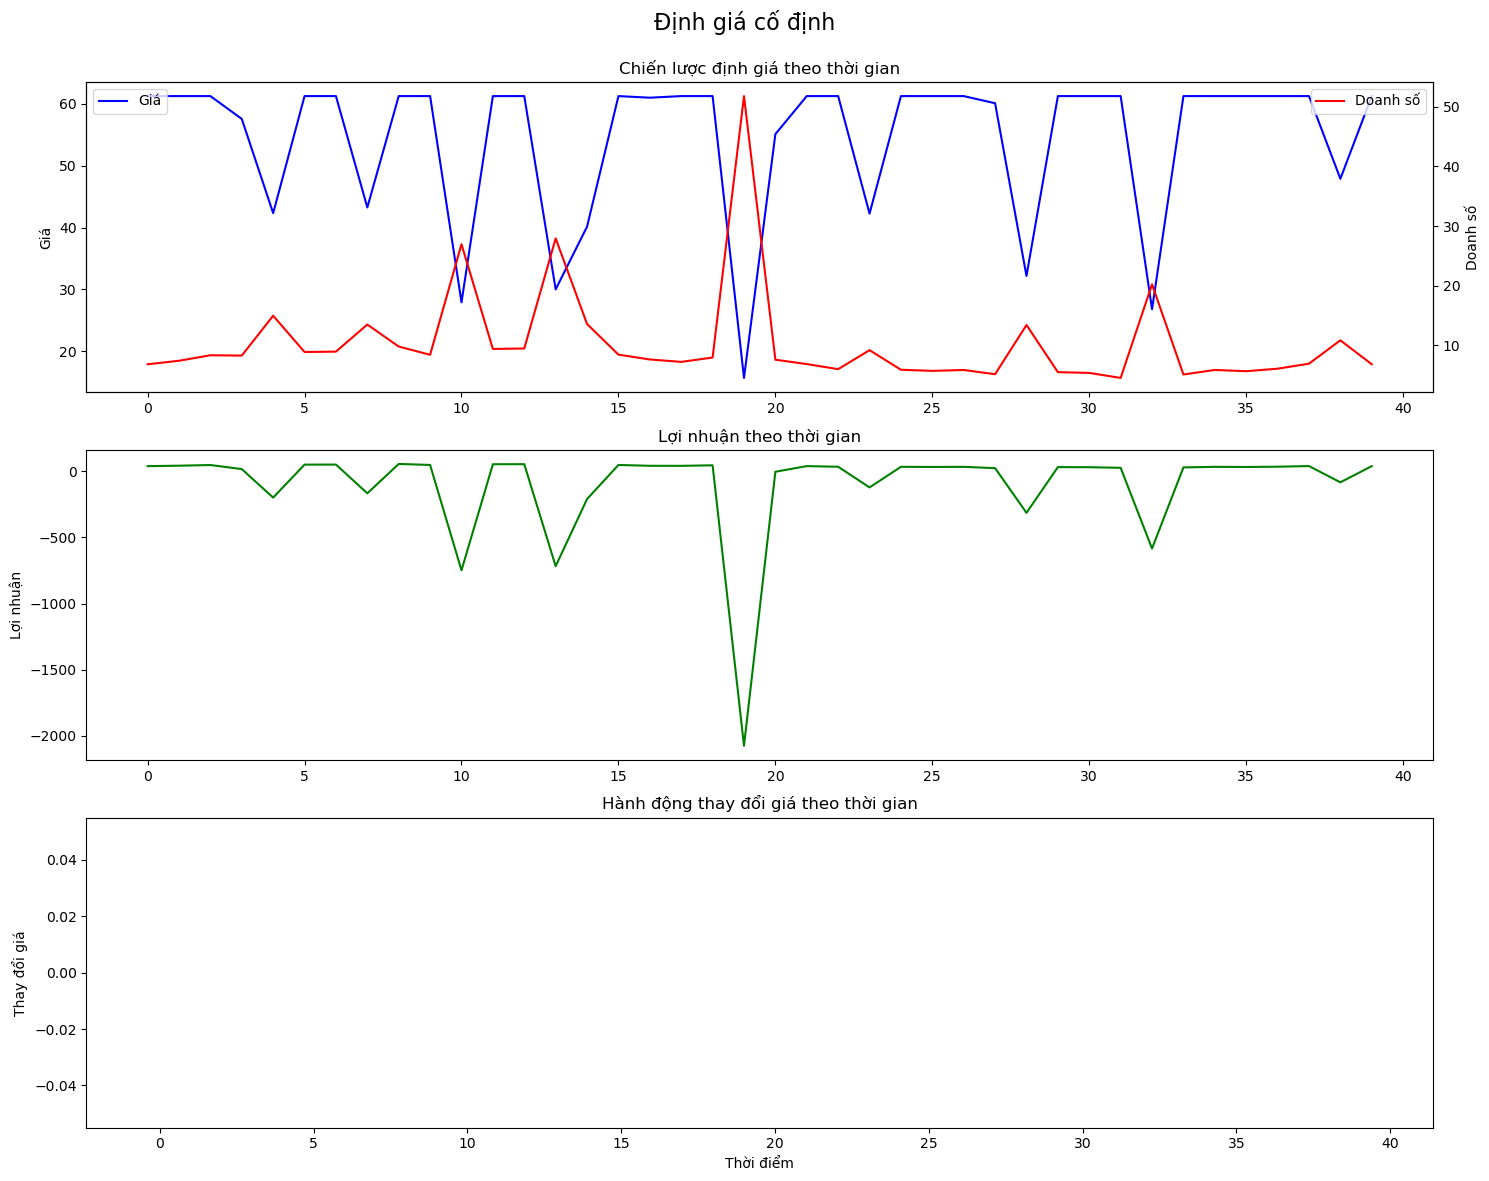

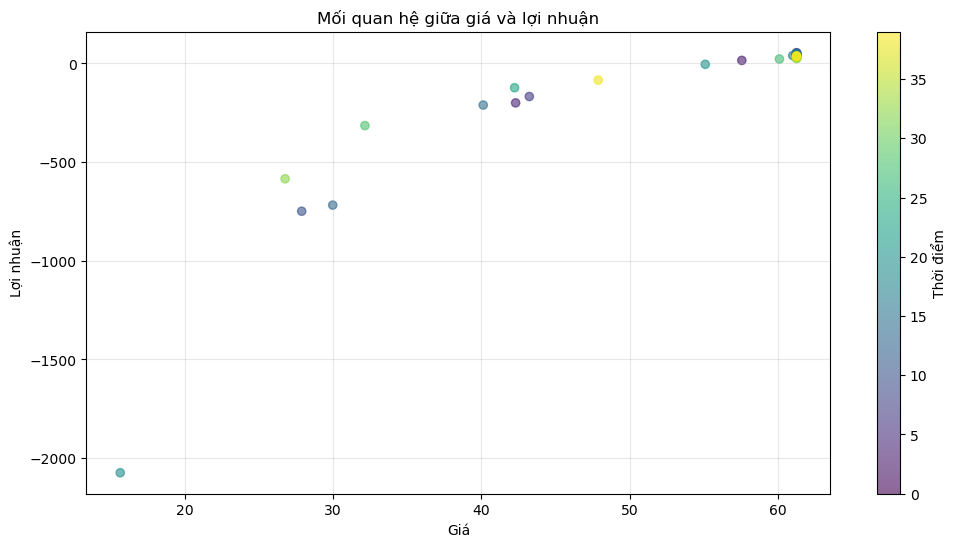


2. Đánh giá PPO tiêu chuẩn...
Episode 1/50, Reward: 55.23, Avg Reward: 55.23


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30348\700575388.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = torch.tensor(actions, dtype=torch.long)


Episode 10/50, Reward: 2207.29, Avg Reward: 160.47
Episode 20/50, Reward: 255.74, Avg Reward: 803.04
Episode 30/50, Reward: 1277.66, Avg Reward: -427.73
Episode 40/50, Reward: -385.47, Avg Reward: -262.14
Episode 50/50, Reward: -45.26, Avg Reward: 373.21

=== Kết thúc huấn luyện PPO tiêu chuẩn ===
Tổng thời gian huấn luyện: 7.88 giây

=== Phân tích Hiệu suất ===
Tổng lợi nhuận: -3724.60
Lợi nhuận trung bình: -93.12 ± 360.75
Số lần thay đổi giá: 38 (95.0%)


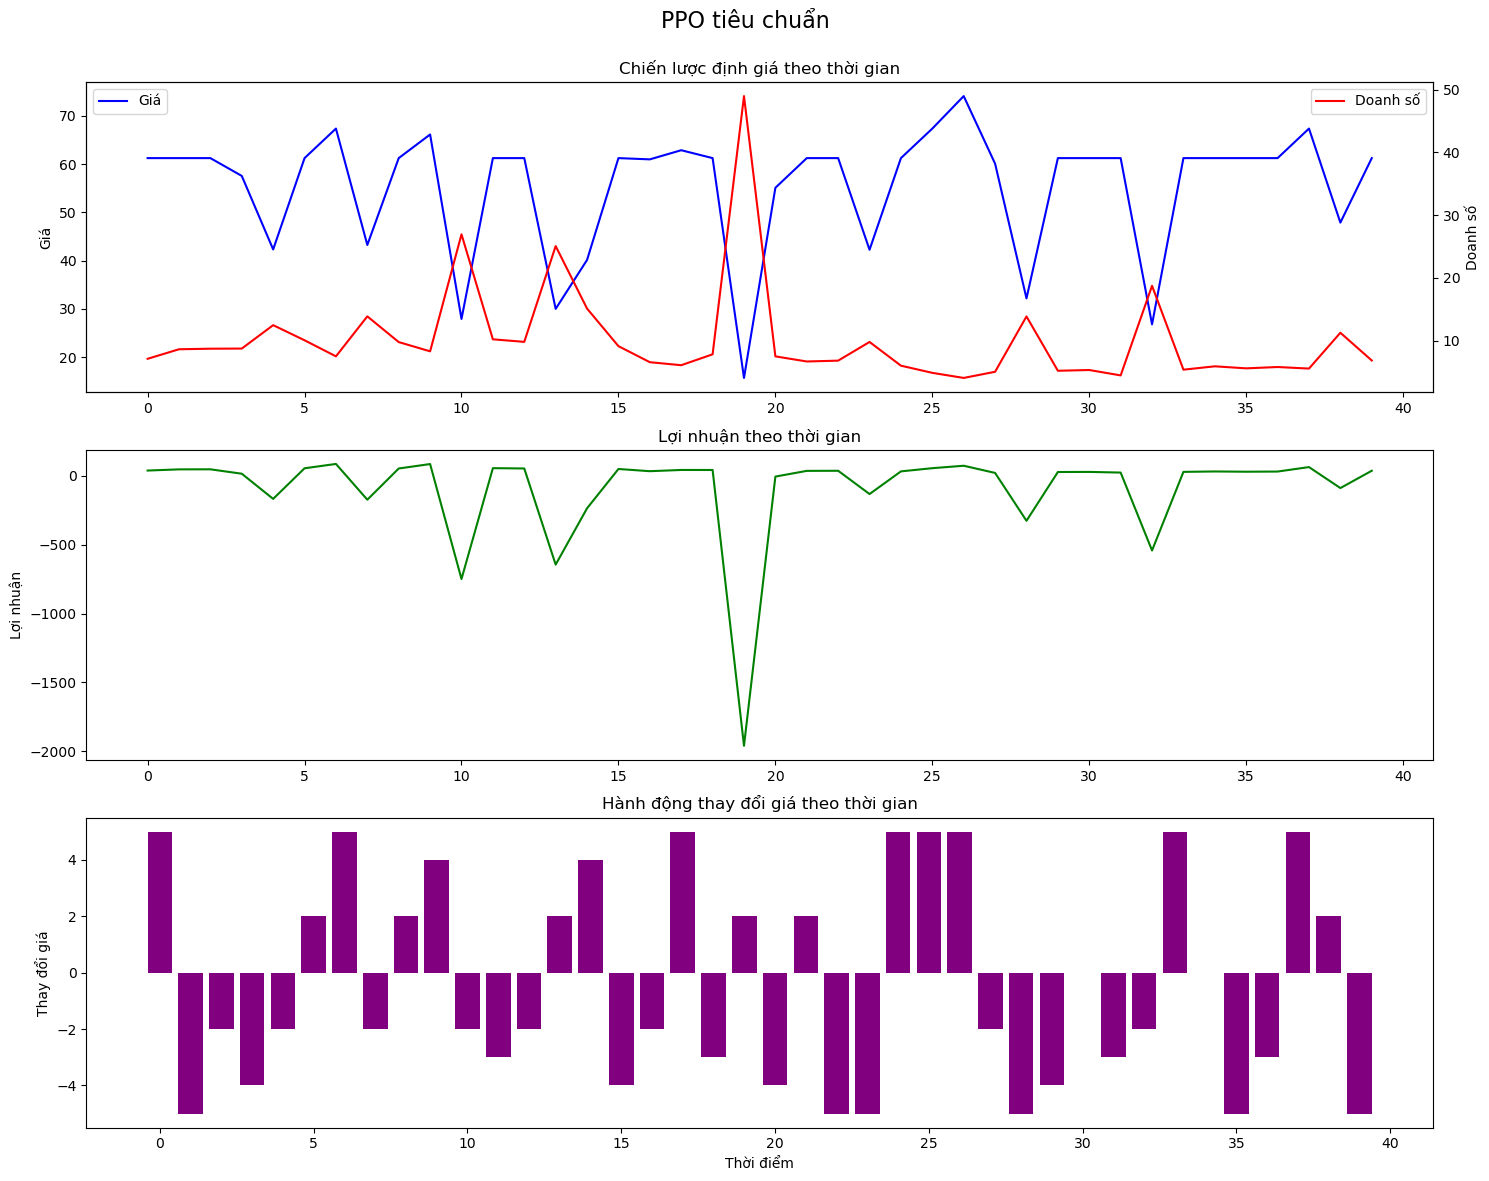

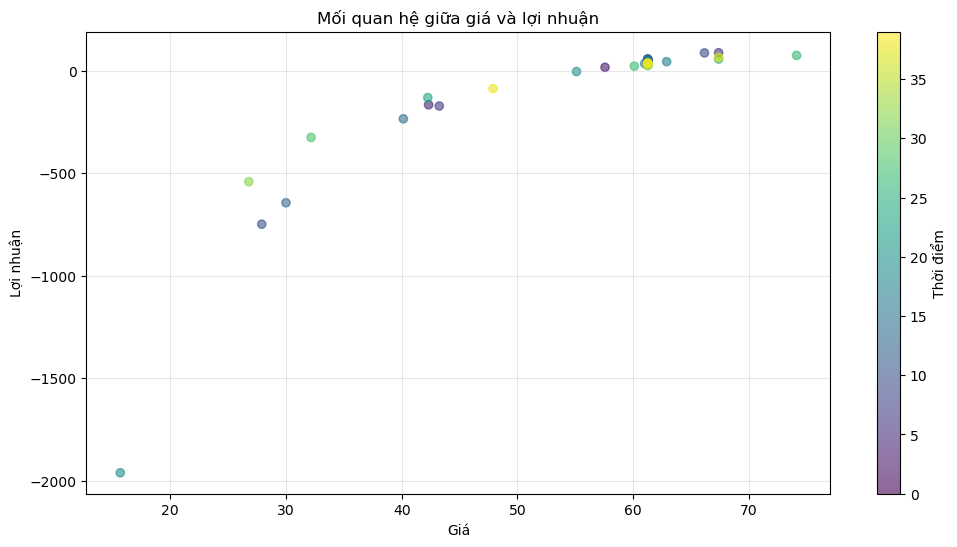


3. Đánh giá Hybrid PPO-GA...

=== Thế hệ 1/8 ===
  Agent 1: score = -1239.68
  Agent 2: score = -787.79
  Agent 3: score = 188.10
  Agent 4: score = -2667.16
  Agent 5: score = 755.62
  Agent 6: score = -1367.92
  → Agent tốt nhất mới: score = 755.62
  Agent tốt nhất trong thế hệ: 5, score = 755.62
  Điểm trung bình: -853.14
  Siêu tham số tốt nhất: {'lr_actor': 0.0003, 'lr_critic': 0.0003, 'gamma': 0.99, 'epsilon': 0.2, 'entropy_coef': 0.01, 'hidden_dim': 64}
  Thời gian thực thi: 1.10 giây

=== Thế hệ 2/8 ===
  Agent 1: score = 361.13
  Agent 2: score = -50.66
  Agent 3: score = 2617.68
  Agent 4: score = 2637.06
  Agent 5: score = 1972.87
  Agent 6: score = 649.62
  → Agent tốt nhất mới: score = 2637.06
  Agent tốt nhất trong thế hệ: 4, score = 2637.06
  Điểm trung bình: 1364.62
  Siêu tham số tốt nhất: {'lr_actor': 0.0003, 'lr_critic': 0.0003, 'gamma': 0.99, 'epsilon': 0.2, 'entropy_coef': 0.01, 'hidden_dim': 64}
  Thời gian thực thi: 1.07 giây

=== Thế hệ 3/8 ===
  Agent 1: score

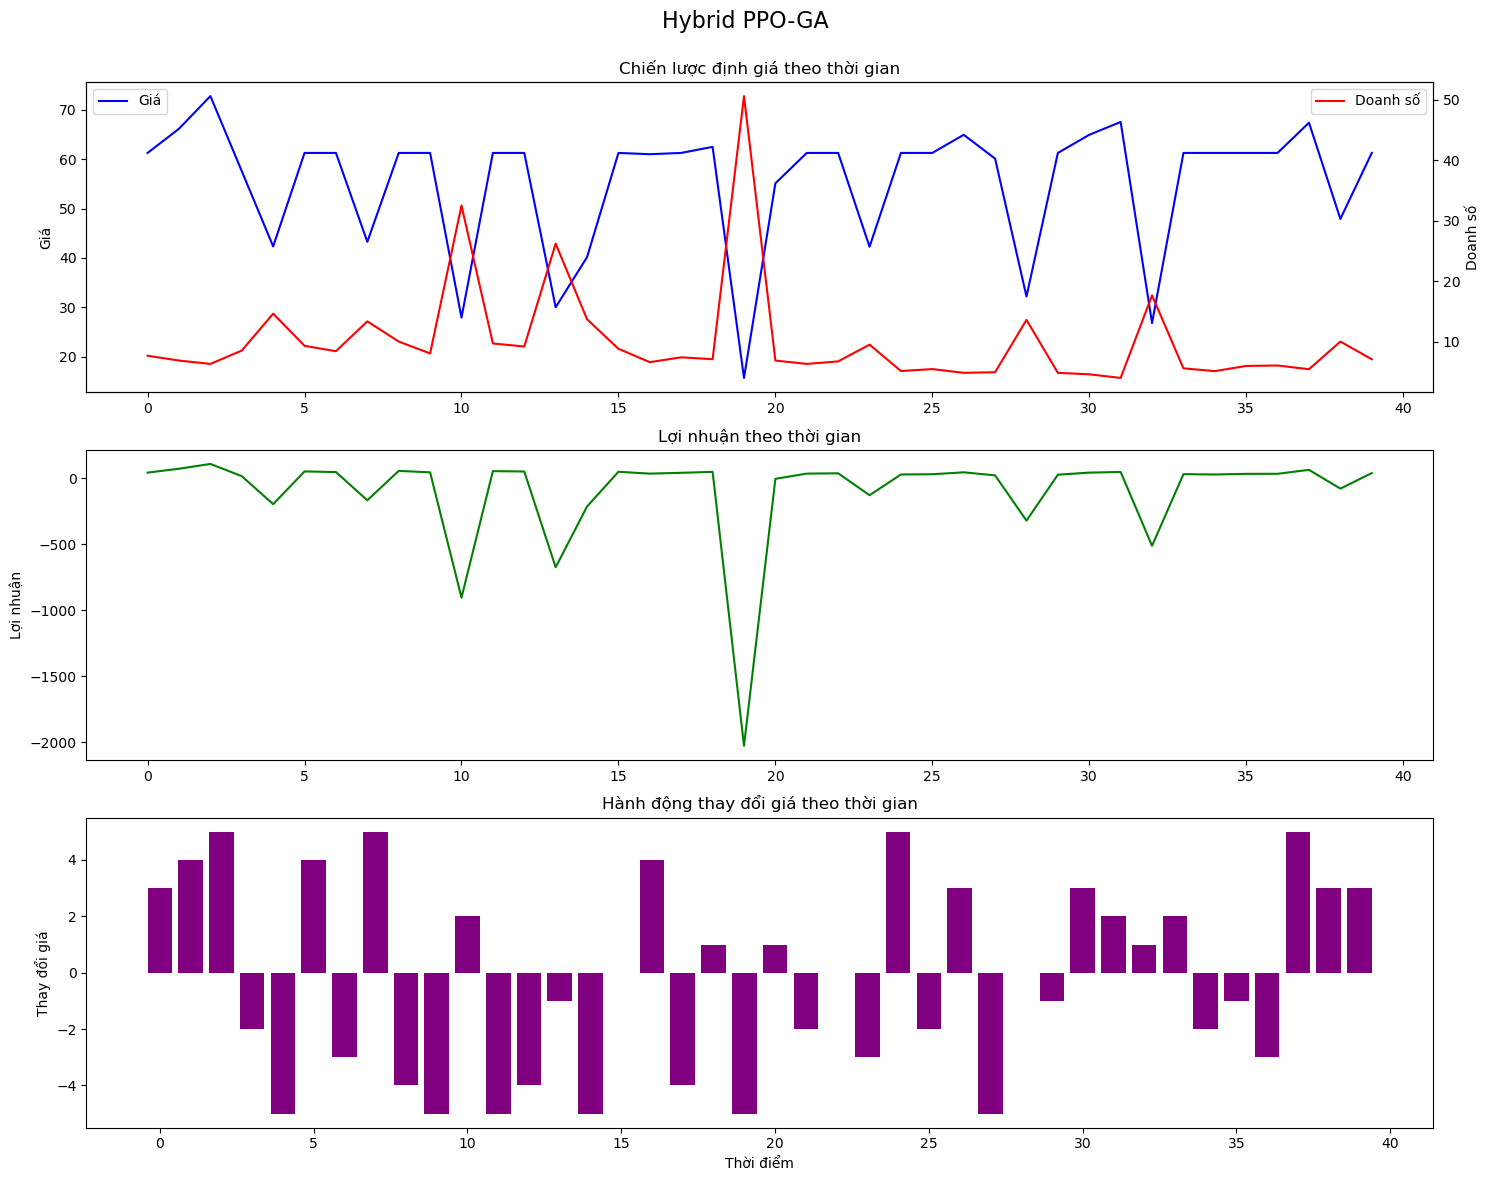

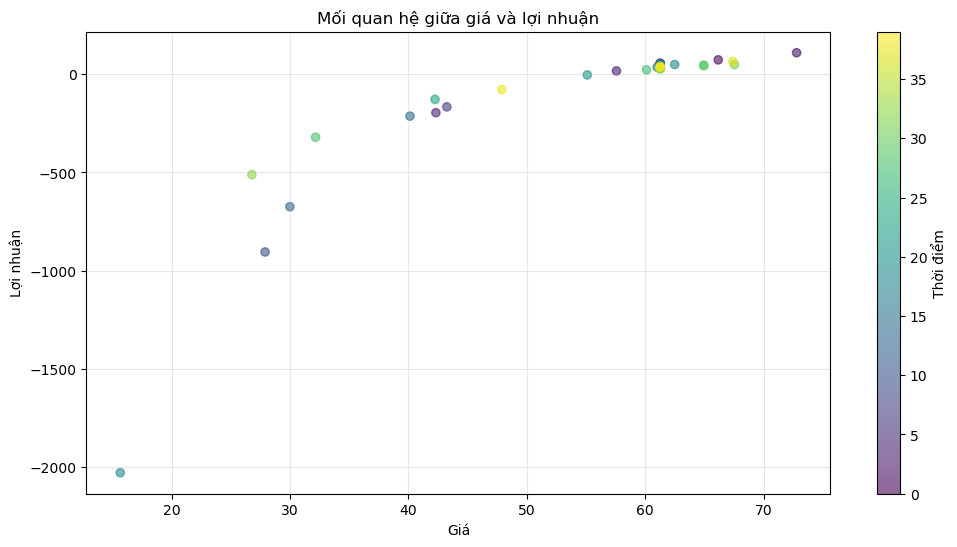


===== Kết quả so sánh =====
     Phương pháp  Tổng lợi nhuận  Cải thiện (%)
Định giá cố định    -4136.384899       0.000000
  PPO tiêu chuẩn      878.865283    -121.247183
   Hybrid PPO-GA     2315.803820    -155.986178


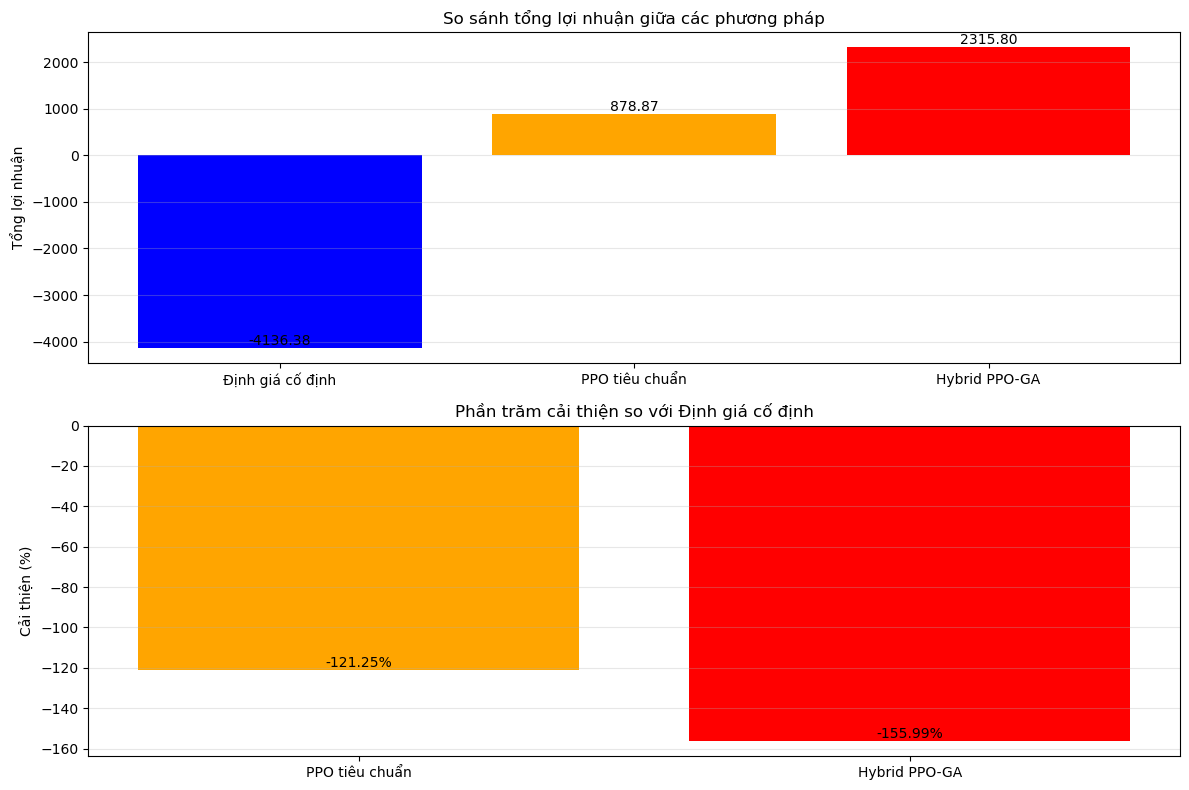

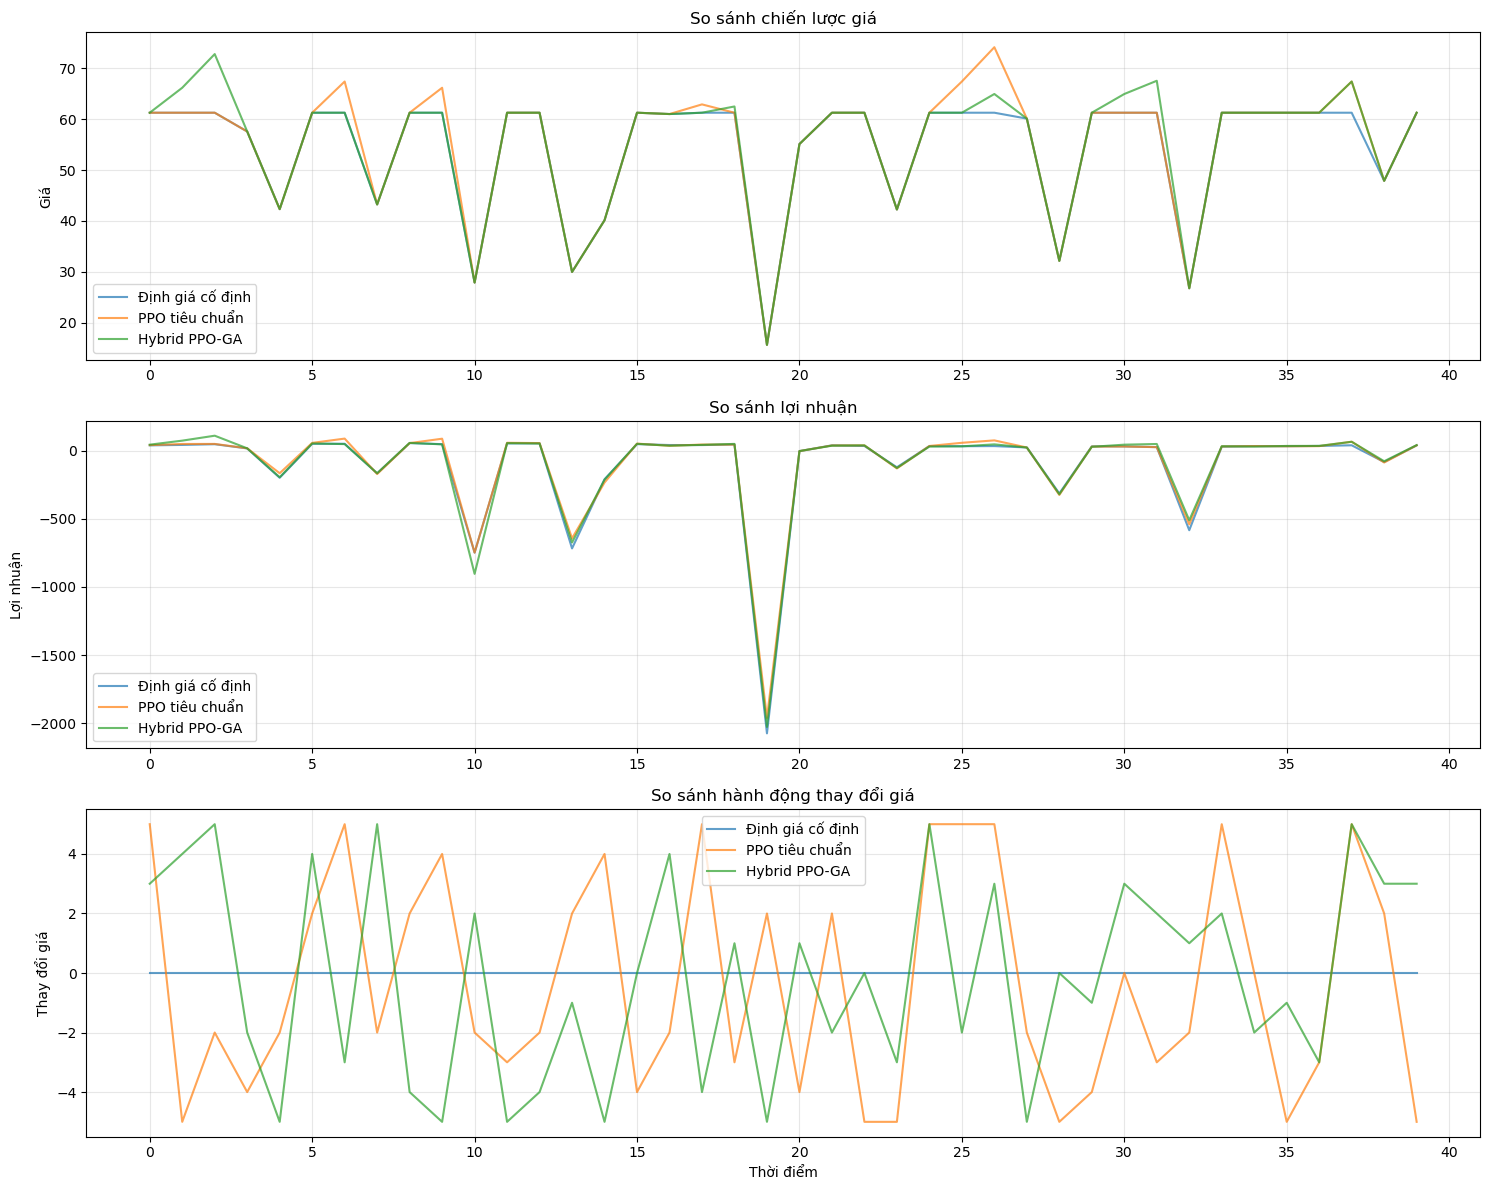


===== Phân tích thống kê chi tiết =====
     Phương pháp  Tổng lợi nhuận  Lợi nhuận trung bình  Độ lệch chuẩn lợi nhuận  Giá trung bình  Tỷ lệ tăng giá (%)  Tỷ lệ giảm giá (%)  Tỷ lệ giữ nguyên giá (%)
Định giá cố định    -4136.384899           -103.409622               377.906724       54.373746                 0.0                 0.0                     100.0
  PPO tiêu chuẩn    -3724.600325            -93.115008               360.753405       55.318262                40.0                55.0                       5.0
   Hybrid PPO-GA    -3955.942953            -98.898574               377.397983       55.308614                45.0                47.5                       7.5

===== Siêu tham số tối ưu từ Hybrid PPO-GA =====
lr_actor: 0.0003
lr_critic: 0.0003
gamma: 0.99
epsilon: 0.2
entropy_coef: 0.01
hidden_dim: 64


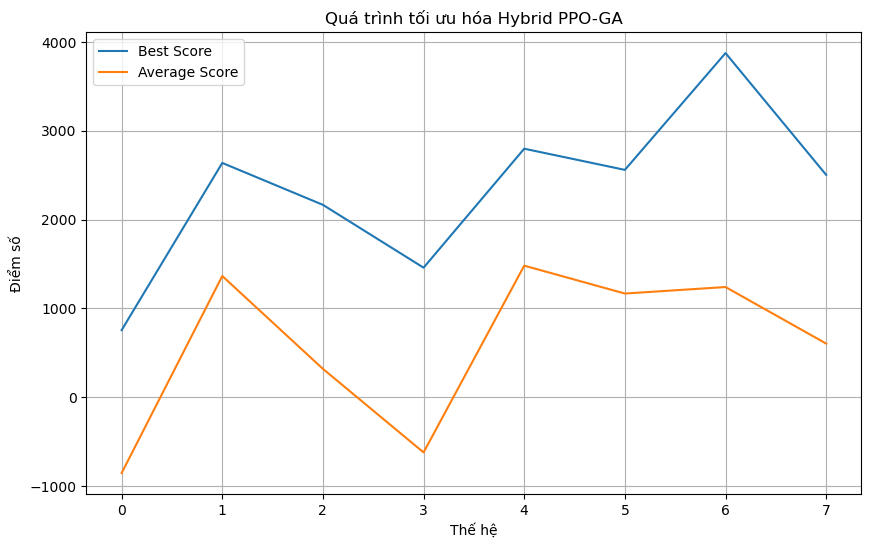

In [16]:
#----------------------------------------------------------------------------------------
# Hàm Main
#----------------------------------------------------------------------------------------
def main():
   """
   Hàm chính để chạy thí nghiệm với bộ dữ liệu Supermarket Sales
   """
   file_path = "supermarket_sales - Sheet1.csv"
   
   try:
       # Tiền xử lý dữ liệu
       print("===== Tiền xử lý dữ liệu Supermarket Sales =====")
       df = preprocess_supermarket_sales(file_path)
       
       # Hiển thị thông tin cơ bản về dữ liệu
       print("\n===== Thông tin dữ liệu =====")
       print(f"Số mẫu: {len(df)}")
       print("\nThống kê mô tả:")
       print(df.describe().round(2))
       
       # Chọn một sản phẩm cụ thể cho thí nghiệm
       product_lines = df['Product line'].unique()
       print("\nDanh mục sản phẩm có sẵn:")
       for i, line in enumerate(product_lines):
           print(f"{i+1}. {line}")
       
       selected_line = product_lines[0]  # Hoặc chọn theo đầu vào người dùng
       print(f"\nChọn danh mục: {selected_line}")
       
       # Tìm product ID cho danh mục đã chọn với doanh số cao nhất
       product_sales = df[df['Product line'] == selected_line].groupby('ProductID')['Quantity'].sum()
       if len(product_sales) > 0:
           product_id = product_sales.idxmax()
           print(f"Chọn sản phẩm bán chạy nhất trong danh mục: {product_id}, Doanh số: {product_sales.max()}")
       else:
           product_id = None  # Để môi trường tự chọn
           print("Không tìm thấy sản phẩm phù hợp, môi trường sẽ tự chọn sản phẩm bán chạy nhất.")
       
       # Khởi tạo môi trường
       env = SupermarketEnv(df, product_id=product_id)
       print(f"\nThông tin môi trường:")
       print(f"Sản phẩm: {env.product_id}")
       print(f"Giá cơ sở: {env.product_info['base_price']:.2f}")
       print(f"Chi phí: {env.product_info['cost']:.2f}")
       print(f"Số lượng bản ghi: {len(env.product_data)}")
       
       # So sánh các phương pháp
       results = compare_all_methods(df, env, product_id)
       
       # Hiển thị siêu tham số tối ưu
       if 'ppo_ga' in results:
           ppo_ga_history = results['ppo_ga'][2]
           if 'best_hyperparams' in ppo_ga_history and ppo_ga_history['best_hyperparams']:
               best_hyperparams = ppo_ga_history['best_hyperparams'][-1]
               print("\n===== Siêu tham số tối ưu từ Hybrid PPO-GA =====")
               for param, value in best_hyperparams.items():
                   print(f"{param}: {value}")
               
               # Trực quan hóa quá trình tối ưu hóa
               plt.figure(figsize=(10, 6))
               plt.plot(ppo_ga_history['best_scores'], label='Best Score')
               plt.plot(ppo_ga_history['avg_scores'], label='Average Score')
               plt.title('Quá trình tối ưu hóa Hybrid PPO-GA')
               plt.xlabel('Thế hệ')
               plt.ylabel('Điểm số')
               plt.legend()
               plt.grid(True)
               plt.show()
       
   except Exception as e:
       print(f"Lỗi trong quá trình thực thi: {e}")
       import traceback
       traceback.print_exc()

if __name__ == "__main__":
   main()